# **DATA MODELLING (Part2)**


In this notebook we explore a different approach to understanding how weather affects traffic fatalities. Instead of summarizing each year into a single set of values, we work with detailed daily accident and weather records to build a richer view of short-term conditions. However, the **model itself uses weekly aggregated data**, because weekly patterns are more stable and less noisy than day-by-day counts, giving the model a more reliable signal to learn from.

The main idea is to capture short-term effects of weather on safety that might be lost in annual averages while avoiding the extreme randomness of daily fatal crash data. This allows us to study:

- how weekly patterns in temperature, precipitation, wind, snowfall, cloud cover, and humidity relate to fatal crashes
- whether extreme weather has immediate, short-term impacts
- whether multiple localized geographic points improve predictive accuracy

We also experiment on a single state - **Texas** - and represent it using **five key county centroids**, which capture the major climate regions and provide more realistic local weather conditions:

- **Dallas** - North Texas (storms, cooler winters)
- **El Paso** - West Texas (dry, desert climate)
- **Austin** - Central Texas (transition zone between wet and dry regions)
- **Houston** - Gulf Coast (humid, heavy rainfall, tropical storms)
- **San Antonio** - South Texas (hotter, semi-arid conditions)

Working with all five points provides better geographic coverage, but processing each one requires a separate full daily merge. For this demonstration, we use **only the Dallas region**, because the process is identical for all other locations and can be easily reused when expanding the analysis.


## 1. Imports


In [1]:
import os
import json
import pandas as pd
from pathlib import Path
import requests_cache
from retry_requests import retry
import openmeteo_requests
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import random
import seaborn as sns

project_root = Path(os.getcwd()).parents[0]
weather_dir = project_root / "data" / "weather_texas_full"
weather_dir.mkdir(parents=True, exist_ok=True)

## 2. Fetching daily weather data for Dallas


In [2]:
POINT_NAME = "DALLAS"
DALLAS_LAT = 32.7767
DALLAS_LON = -96.7970

START_YEAR = 1975
END_YEAR = 2023

cache_session = requests_cache.CachedSession(".cache", expire_after=86400)
retry_session = retry(cache_session, retries=5, backoff_factor=0.3)
openmeteo = openmeteo_requests.Client(session=retry_session)

def fetch_full_period(lat, lon):
    url = "https://climate-api.open-meteo.com/v1/climate"
    
    daily_params = [
        "temperature_2m_mean",
        "temperature_2m_max",
        "temperature_2m_min",
        "wind_speed_10m_mean",
        "wind_speed_10m_max",
        "cloud_cover_mean",
        "shortwave_radiation_sum",
        "precipitation_sum",
        "rain_sum",
        "snowfall_sum",
        "relative_humidity_2m_mean"
    ]

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": f"{START_YEAR}-01-01",
        "end_date": f"{END_YEAR}-12-31",
        "models": "EC_Earth3P_HR",
        "timezone": "UTC",
        "daily": daily_params
    }

    return openmeteo.weather_api(url, params=params)[0]


print(f"Fetching daily climate for Dallas ({START_YEAR}-{END_YEAR})")

response = fetch_full_period(DALLAS_LAT, DALLAS_LON)

daily = response.Daily()

var_names = [
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "wind_speed_10m_mean",
    "wind_speed_10m_max",
    "cloudcover_mean",
    "shortwave_radiation_sum",
    "precipitation_sum",
    "rain_sum",
    "snowfall_sum",
    "relative_humidity_2m_mean"
]

daily_arrays = {name: daily.Variables(i).ValuesAsNumpy() for i, name in enumerate(var_names)}

dates = pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
)

df_daily = pd.DataFrame({"date": dates.astype(str)})
for name, arr in daily_arrays.items():
    df_daily[name] = arr

df_daily["year"] = pd.to_datetime(df_daily["date"]).dt.year

output_path = weather_dir / f"{POINT_NAME}_EC_Earth3P_HR_1975_2023.json"

json_obj = {
    "point_name": POINT_NAME,
    "latitude": DALLAS_LAT,
    "longitude": DALLAS_LON,
    "years": f"{START_YEAR}-{END_YEAR}",
    "daily": df_daily.to_dict(orient="records")
}

with open(output_path, "w") as f:
    json.dump(json_obj, f, indent=2)

print(f"Saved Dallas full weather JSON => {output_path}")


Fetching daily climate for Dallas (1975-2023)


OpenMeteoRequestsError: failed to request 'https://climate-api.open-meteo.com/v1/climate': {'error': True, 'reason': 'Hourly API request limit exceeded. Please try again in the next hour.'}

## 3. Extracting accidents near the Dallas region (2010–2023)

In this step, we isolate all accidents that occurred within a defined radius of 75km around the Dallas metropolitan area.  
The goal is to create a daily, location-specific dataset that can later be merged with Dallas-area weather conditions.

To do this, we:

- load accident files for each year from 2010 to 2023, the reason we work only with these years is because before 2010 it wasn't recorded for accidents exactly at which LATITUDE, LONGITUDE they happened
- remove invalid or missing latitude/longitude values based on FARS documentation
- calculate the distance of every crash to the Dallas centroid using the Haversine formula
- keep only crashes that occurred within a **75 km radius** of Dallas
- combine all qualifying crashes into a single dataset
- save the final result as a clean CSV file in `data/dallas_accidents/dallas_accidents_2010_2023.csv`

This gives us a geographically focused accident dataset that matches the scale of the weather data, allowing for more accurate daily-level modelling for the Dallas region.


In [4]:
RADIUS_KM = 75

project_root = Path(os.getcwd()).parents[0]
accident_root = project_root / "data" / "data_accidents"

output_dir = project_root / "data" / "dallas_accidents"
output_dir.mkdir(parents=True, exist_ok=True)

out_path = output_dir / "dallas_accidents_2010_2023.csv"

# Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

def safe_read_csv(path):
    try:
        return pd.read_csv(path, low_memory=False, encoding="utf-8")
    except UnicodeDecodeError:
        return pd.read_csv(path, low_memory=False, encoding="latin1")
    
all_rows = []

INVALID_LAT = {77.7777, 88.8888, 99.9999}
INVALID_LON = {777.7777, 888.8888, 999.9999}

for year in range(2010, 2024):
    file = accident_root / str(year) / "accident.csv"
    
    if not file.exists():
        print(f"Missing file: {file}")
        continue
    
    print(f"Processing {year}")

    df = safe_read_csv(file)

    df = df.dropna(subset=["LATITUDE", "LONGITUD"])
    df = df[~df["LATITUDE"].isin(INVALID_LAT)]
    df = df[~df["LONGITUD"].isin(INVALID_LON)]

    df["distance_km"] = df.apply(
        lambda r: haversine(DALLAS_LAT, DALLAS_LON, r["LATITUDE"], r["LONGITUD"]),
        axis=1
    )

    df_close = df[df["distance_km"] <= RADIUS_KM].copy()
    df_close["YEAR"] = year

    all_rows.append(df_close)

df_dallas = pd.concat(all_rows, ignore_index=True)

print("Total valid Dallas-area accidents:", len(df_dallas))

df_dallas.to_csv(out_path, index=False)

print(f"Saved Dallas accidents => {out_path}")


Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018
Processing 2019
Processing 2020
Processing 2021
Processing 2022
Processing 2023
Total valid Dallas-area accidents: 8297
Saved Dallas accidents => c:\Users\zualuk\OneDrive - fer.hr\Desktop\foundations-of-data-science\data\dallas_accidents\dallas_accidents_2010_2023.csv


## 4. Merging Dallas weather and accident data by date


In [5]:
weather_path = project_root / "data/weather_texas_full/DALLAS_EC_Earth3P_HR_1975_2023.json"

with open(weather_path, "r") as f:
    weather_raw = json.load(f)

weather_df = pd.DataFrame(weather_raw["daily"])

weather_df["date"] = pd.to_datetime(weather_df["date"])
weather_df["date"] = weather_df["date"].dt.tz_localize(None)

# Restrict to 2010–2023
weather_df = weather_df[(weather_df["date"].dt.year >= 2010)]
weather_df = weather_df.fillna(0)

acc_path = project_root / "data/dallas_accidents/dallas_accidents_2010_2023.csv"
acc_df = pd.read_csv(acc_path)

acc_df["date"] = pd.to_datetime(
    acc_df[["YEAR", "MONTH", "DAY"]].astype(str).agg("-".join, axis=1),
    errors="coerce"
)

merged_df = acc_df.merge(weather_df, on="date", how="left")
out_path = project_root / "data/dallas_accidents/dallas_weather_accidents_2010_2023.csv"
merged_df.to_csv(out_path, index=False)

print(f"Merged dataset saved to: {out_path}")

C:\Users\zualuk\AppData\Local\Temp\ipykernel_15736\2265267904.py:16: DtypeWarning: Columns (77,78,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  acc_df = pd.read_csv(acc_path)


Merged dataset saved to: c:\Users\zualuk\OneDrive - fer.hr\Desktop\foundations-of-data-science\data\dallas_accidents\dallas_weather_accidents_2010_2023.csv


# 5. Two Weather-Based Prediction Models


## 5.1. Model 1 (Weekly predictions)


What this model learns and predicts?

This model is trained on **weekly-level features** derived from daily accident and weather data.  
It learns patterns from:

- weekly totals of fatal crashes, total crashes, and drunk-driving involvement
- weekly summaries of temperature, precipitation, wind, humidity, cloud cover, and radiation
- time-related variables such as year, week number, and weekend indicators

Using these inputs, the model first predicts **the number of fatalities due to fatal crashes in each upcoming week** and then **the number of fatal crashes in each upcoming week**, in the Dallas region.  
In other words, it learns how weekly weather conditions and temporal patterns relate to weekly fatality and in general fatal crash counts.


C:\Users\zualuk\AppData\Local\Temp\ipykernel_15736\1353178604.py:3: DtypeWarning: Columns (77,78,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, parse_dates=["date"])


(731, 18)
Train: (470, 16) Test: (261, 16)
Model trained.
RMSE: 1.788482105446083
MAE: 1.257482647895813


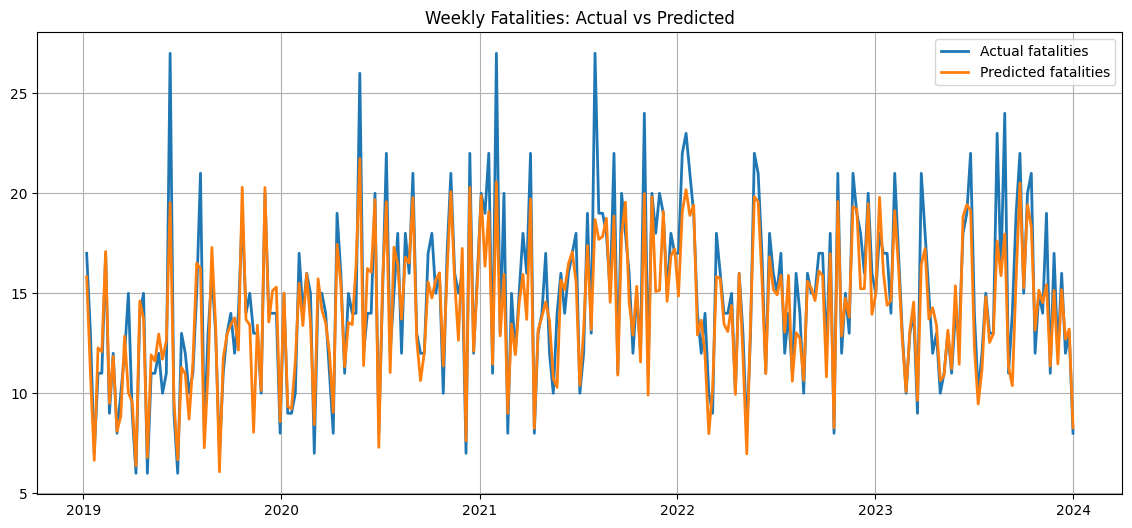

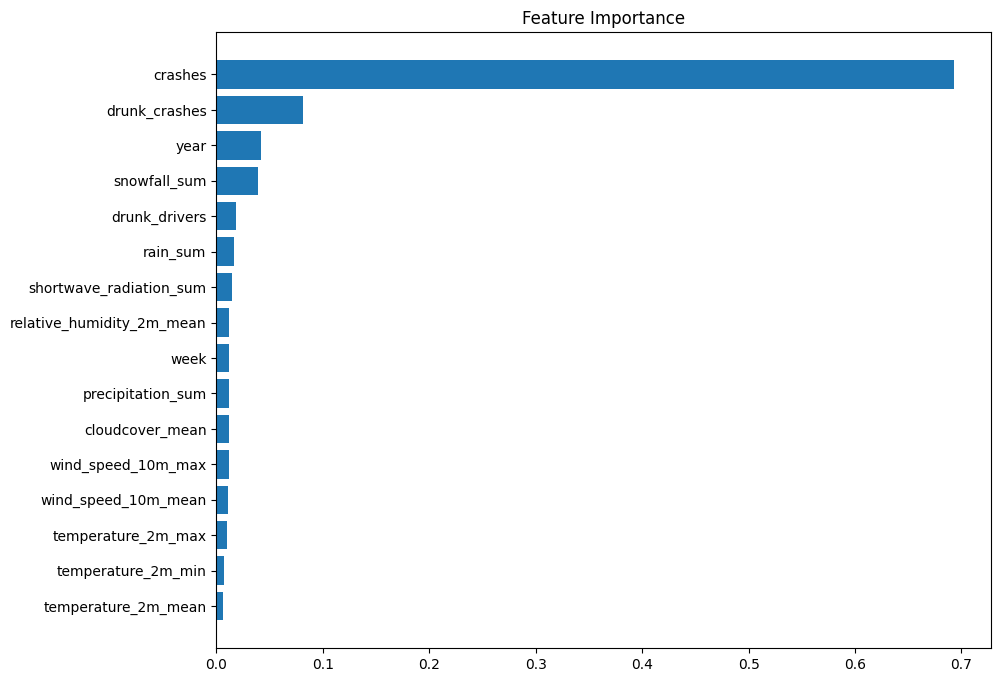

In [6]:
data_path = project_root / "data/dallas_accidents" / "dallas_weather_accidents_2010_2023.csv"

df = pd.read_csv(data_path, parse_dates=["date"])

weather_cols = [
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "wind_speed_10m_mean",
    "wind_speed_10m_max",
    "cloudcover_mean",
    "shortwave_radiation_sum",
    "precipitation_sum",
    "rain_sum",
    "snowfall_sum",
    "relative_humidity_2m_mean",
]

daily = (
    df.groupby("date")
      .agg(
          fatalities=("FATALS", "sum"),
          crashes=("ST_CASE", "nunique"),

          # Number of drunk drivers involved in all fatal crashes that day
          drunk_drivers=("DRUNK_DR", "sum"),

          # Number of drunk driver crashes (more than 1 drunk driver involved)
          drunk_crashes=("DRUNK_DR", lambda x: (x > 0).sum()),

          # Weather features
          **{col: (col, "mean") for col in weather_cols}
      )
      .reset_index()
)

daily["year"] = daily["date"].dt.year
daily["month"] = daily["date"].dt.month
daily["dayofweek"] = daily["date"].dt.dayofweek
daily["is_weekend"] = daily["dayofweek"].isin([5, 6]).astype(int)

weekly = (
    daily.set_index("date")
         .resample("W-MON")   # weekly periods starting on Monday
         .agg({
             "fatalities": "sum",
             "crashes": "sum",
             "drunk_drivers": "sum",
             "drunk_crashes": "sum",
             "temperature_2m_mean": "mean",
             "temperature_2m_max": "max",
             "temperature_2m_min": "min",
             "wind_speed_10m_mean": "mean",
             "wind_speed_10m_max": "max",
             "cloudcover_mean": "mean",
             "shortwave_radiation_sum": "sum",
             "precipitation_sum": "sum",
             "rain_sum": "sum",
             "snowfall_sum": "sum",
             "relative_humidity_2m_mean": "mean"
         })
         .reset_index()
)
             
weekly["year"] = weekly["date"].dt.year
weekly["week"] = weekly["date"].dt.isocalendar().week.astype(int)

print(weekly.shape)
weekly.head()


# train / test split
train = weekly[weekly["date"].dt.year <= 2018]
test  = weekly[weekly["date"].dt.year >= 2019]

target_col = "fatalities"

# we are not giving the number of fatalities to the model, since that is the variable it has to predict
X_train = train.drop(columns=["fatalities", "date"])
y_train = train[target_col]

X_test  = test.drop(columns=["fatalities", "date"])
y_test  = test[target_col]

print("Train:", X_train.shape, "Test:", X_test.shape)


# training the model
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train, y_train)

print("Model trained.")

# evaluating the model
pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("RMSE:", rmse)
print("MAE:", mae)

plt.figure(figsize=(14,6))
plt.plot(test["date"], y_test, label="Actual fatalities", linewidth=2)
plt.plot(test["date"], pred, label="Predicted fatalities", linewidth=2)
plt.legend()
plt.title("Weekly Fatalities: Actual vs Predicted")
plt.grid()
plt.show()

plt.figure(figsize=(10,8))
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.barh(np.array(X_train.columns)[indices], importances[indices])
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.show()

**Conclusion**

The weekly prediction model manages to follow the overall movements and seasonal patterns of fatalities in the Dallas area, but weekly fatalities remain difficult to predict with high precision. The RMSE and MAE values show that the model captures general trends but often misses sharp weekly spikes.

Feature importance reveals that the model relies mostly on **crash-related variables** (total weekly crashes, drunk-driving involvement) rather than weather features. Weather plays only a minor role in weekly fatality prediction, while underlying behavioral factors dominate. Overall, weekly weather summaries provide limited predictive power compared to structural and behavioral indicators.


Now the same process of learning (on the same data), but now it predicts the **number of weekly fatal crashes**:


C:\Users\zualuk\AppData\Local\Temp\ipykernel_15736\321012386.py:1: DtypeWarning: Columns (77,78,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, parse_dates=["date"])


Train: (470, 16) Test: (261, 16)
Model trained (fatal crashes).
Fatal Crash Prediction - RMSE: 1.7184675504780118
Fatal Crash Prediction - MAE: 1.2304818630218506


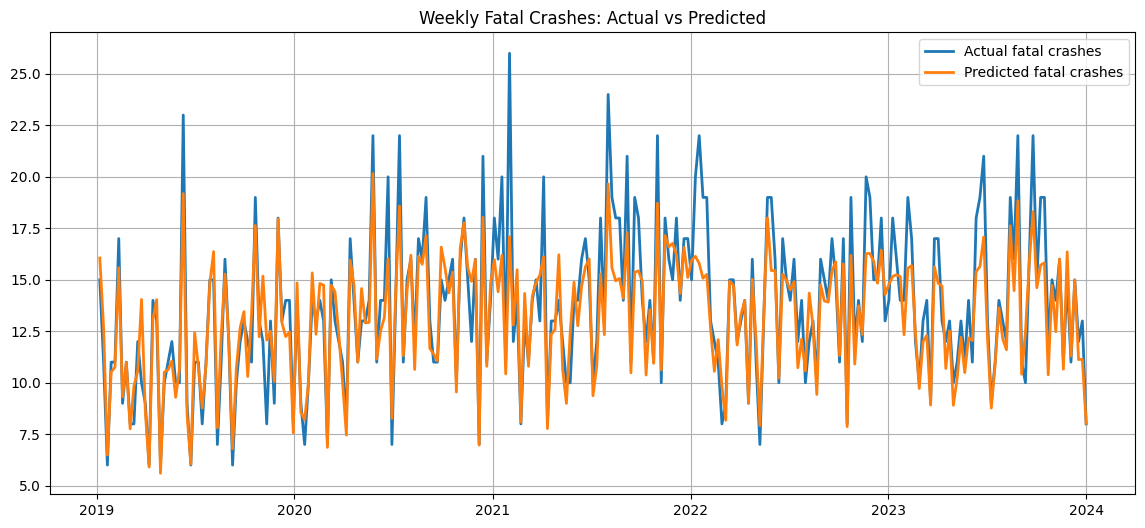

Chosen week: YEAR=2019, WEEK=32, starting 2019-08-05
Actual fatal crashes: 15
Predicted fatal crashes: 16.37


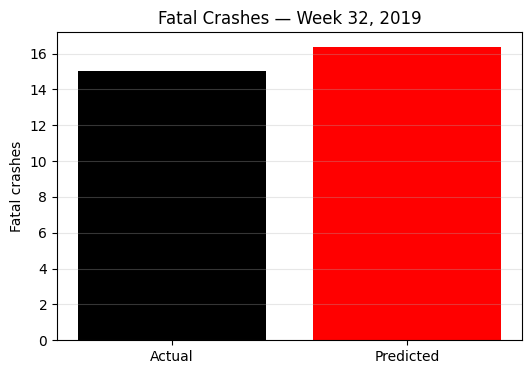

In [7]:
df = pd.read_csv(data_path, parse_dates=["date"])

weather_cols = [
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "wind_speed_10m_mean",
    "wind_speed_10m_max",
    "cloudcover_mean",
    "shortwave_radiation_sum",
    "precipitation_sum",
    "rain_sum",
    "snowfall_sum",
    "relative_humidity_2m_mean",
]

daily = (
    df.groupby("date")
      .agg(
          fatalities=("FATALS", "sum"),
          crashes=("ST_CASE", "nunique"),

          drunk_drivers=("DRUNK_DR", "sum"),
          drunk_crashes=("DRUNK_DR", lambda x: (x > 0).sum()),

          **{col: (col, "mean") for col in weather_cols}
      )
      .reset_index()
)

daily["year"] = daily["date"].dt.year
daily["month"] = daily["date"].dt.month
daily["dayofweek"] = daily["date"].dt.dayofweek
daily["is_weekend"] = daily["dayofweek"].isin([5,6]).astype(int)

weekly = (
    daily.set_index("date")
         .resample("W-MON")
         .agg({
             "fatalities": "sum",
             "crashes": "sum",
             "drunk_drivers": "sum",
             "drunk_crashes": "sum",

             "temperature_2m_mean": "mean",
             "temperature_2m_max": "mean",
             "temperature_2m_min": "mean",
             "wind_speed_10m_mean": "mean",
             "wind_speed_10m_max": "mean",
             "cloudcover_mean": "mean",
             "shortwave_radiation_sum": "mean",
             "precipitation_sum": "mean",
             "rain_sum": "mean",
             "snowfall_sum": "mean",
             "relative_humidity_2m_mean": "mean",
         })
         .reset_index()
)

weekly["year"] = weekly["date"].dt.year
weekly["week"] = weekly["date"].dt.isocalendar().week.astype(int)


train = weekly[weekly["date"].dt.year <= 2018]
test  = weekly[weekly["date"].dt.year >= 2019]

target_col = "crashes"

# we are not giving the number of crashes to the model, since that is the variable it has to predict
X_train = train.drop(columns=["crashes", "date"])
y_train = train[target_col]

X_test  = test.drop(columns=["crashes", "date"])
y_test  = test[target_col]

print("Train:", X_train.shape, "Test:", X_test.shape)

model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train, y_train)
print("Model trained (fatal crashes).")


pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)

print("Fatal Crash Prediction - RMSE:", rmse)
print("Fatal Crash Prediction - MAE:", mae)

plt.figure(figsize=(14,6))
plt.plot(test["date"], y_test, label="Actual fatal crashes", linewidth=2)
plt.plot(test["date"], pred, label="Predicted fatal crashes", linewidth=2)
plt.legend()
plt.title("Weekly Fatal Crashes: Actual vs Predicted")
plt.grid()
plt.show()

# Pick a random week (2019–2023)
valid_weeks = weekly[(weekly["year"] >= 2019)]
chosen_row = valid_weeks.sample(1, random_state=42).iloc[0]

chosen_date = chosen_row["date"]
chosen_year = chosen_row["year"]
chosen_week = chosen_row["week"]

print(f"Chosen week: YEAR={chosen_year}, WEEK={chosen_week}, starting {chosen_date.date()}")

actual_val = y_test.loc[chosen_row.name]
pred_val = pred[list(y_test.index).index(chosen_row.name)]

print("Actual fatal crashes:", actual_val)
print("Predicted fatal crashes:", round(pred_val, 2))

plt.figure(figsize=(6,4))
plt.bar(["Actual", "Predicted"], [actual_val, pred_val], color=["black", "red"])
plt.title(f"Fatal Crashes — Week {chosen_week}, {chosen_year}")
plt.ylabel("Fatal crashes")
plt.grid(axis="y", alpha=0.3)
plt.show()

**Conclusion**

This model is able to follow the overall weekly pattern of fatal crashes in the Dallas area, but individual weeks still show substantial variation that the model cannot fully capture. The RMSE and MAE indicate that the model captures general trends reasonably well, and the example week shows that predictions are usually close to the real values. However, the results also confirm that short-term fatal crash fluctuations are driven more by unpredictable human and traffic factors than by weekly weather summaries.


## 5.2. Model 2 (Weekly predictions, but based just on weather)


C:\Users\zualuk\AppData\Local\Temp\ipykernel_15736\1854580523.py:3: DtypeWarning: Columns (77,78,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, parse_dates=["date"])


Model based just on the weather (number of fatalities)
RMSE: 5.126315808602826
MAE: 4.030420303344727
Model based just on the weather (number of fatal crashes)
RMSE: 4.583368520890614
MAE: 3.5947868824005127


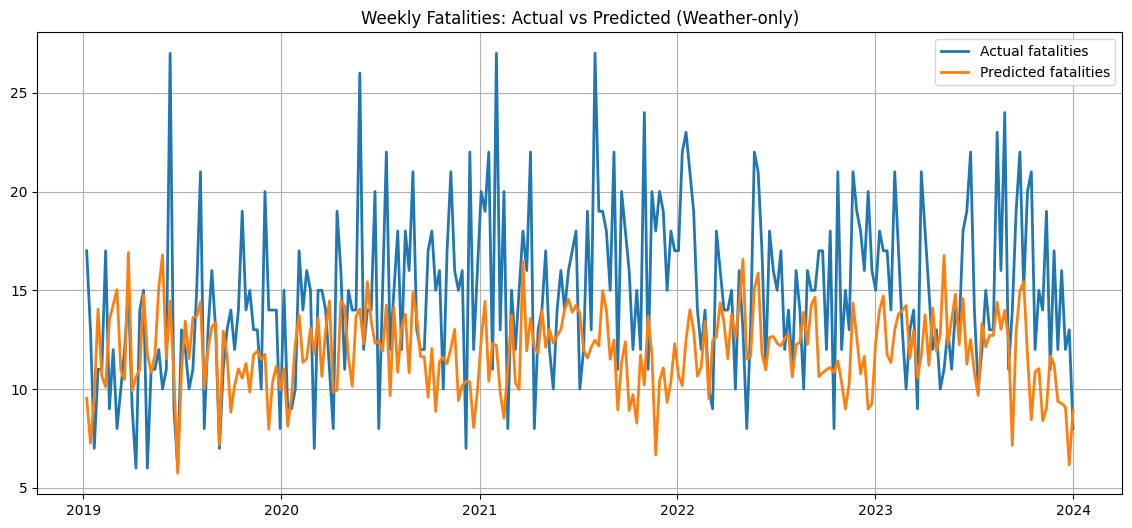

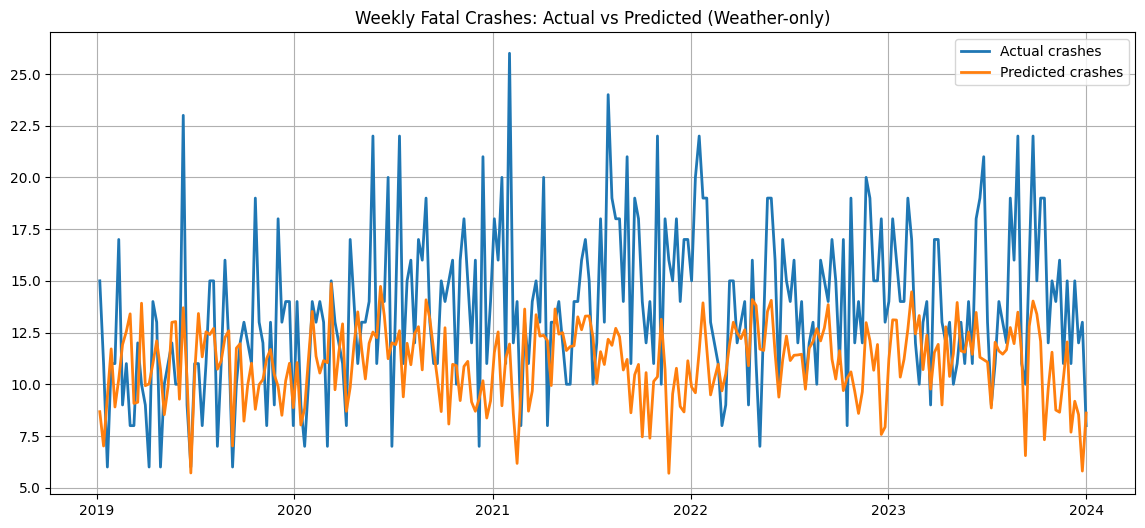


Random Week selected: Week 26, 2022


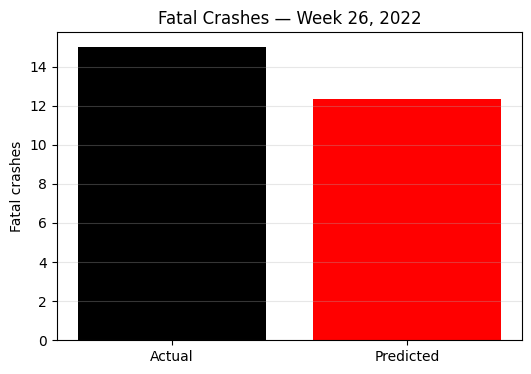

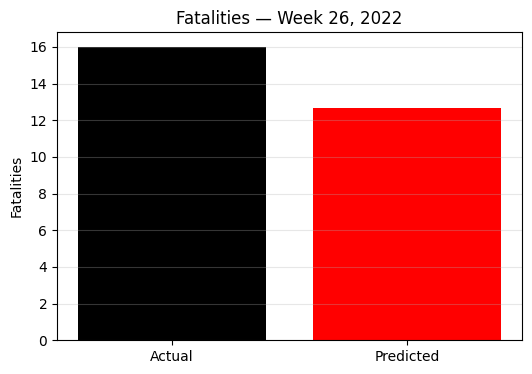

In [8]:
data_path = project_root / "data/dallas_accidents" / "dallas_weather_accidents_2010_2023.csv"

df = pd.read_csv(data_path, parse_dates=["date"])

weather_cols = [
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "wind_speed_10m_mean",
    "wind_speed_10m_max",
    "cloudcover_mean",
    "shortwave_radiation_sum",
    "precipitation_sum",
    "rain_sum",
    "snowfall_sum",
    "relative_humidity_2m_mean",
]

daily = (
    df.groupby("date")
      .agg(
          fatalities=("FATALS", "sum"),
          crashes=("ST_CASE", "nunique"),
          drunk_drivers=("DRUNK_DR", "sum"),
          drunk_crashes=("DRUNK_DR", lambda x: (x > 0).sum()),
          **{col: (col, "mean") for col in weather_cols}
      )
      .reset_index()
)

daily["year"] = daily["date"].dt.year

weekly = (
    daily.set_index("date")
         .resample("W-MON")
         .agg({
             "fatalities": "sum",
             "crashes": "sum",
             "drunk_drivers": "sum",
             "drunk_crashes": "sum",
             "temperature_2m_mean": "mean",
             "temperature_2m_max": "max",
             "temperature_2m_min": "min",
             "wind_speed_10m_mean": "mean",
             "wind_speed_10m_max": "max",
             "cloudcover_mean": "mean",
             "shortwave_radiation_sum": "sum",
             "precipitation_sum": "sum",
             "rain_sum": "sum",
             "snowfall_sum": "sum",
             "relative_humidity_2m_mean": "mean",
         })
         .reset_index()
)

weekly["year"] = weekly["date"].dt.year
weekly["week"] = weekly["date"].dt.isocalendar().week.astype(int)

train = weekly[weekly["date"].dt.year <= 2018]
test  = weekly[weekly["date"].dt.year >= 2019]

weather_features_only = [
    "temperature_2m_mean",
    "temperature_2m_max",
    "temperature_2m_min",
    "wind_speed_10m_mean",
    "wind_speed_10m_max",
    "cloudcover_mean",
    "shortwave_radiation_sum",
    "precipitation_sum",
    "rain_sum",
    "snowfall_sum",
    "relative_humidity_2m_mean",
]

# first we predict the fatalities, but just based on the weather features
target_fatal = "fatalities"

X_train_fatal = train[weather_features_only]
y_train_fatal = train[target_fatal]

X_test_fatal  = test[weather_features_only]
y_test_fatal  = test[target_fatal]

model_fatal = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model_fatal.fit(X_train_fatal, y_train_fatal)

pred_fatal = model_fatal.predict(X_test_fatal)

rmse_fatal = np.sqrt(mean_squared_error(y_test_fatal, pred_fatal))
mae_fatal = mean_absolute_error(y_test_fatal, pred_fatal)

print("Model based just on the weather (number of fatalities)")
print("RMSE:", rmse_fatal)
print("MAE:", mae_fatal)

# then we predict the number of crashes, but again based just on the weather features
target_crashes = "crashes"

X_train_crash = train[weather_features_only]
y_train_crash = train[target_crashes]

X_test_crash  = test[weather_features_only]
y_test_crash  = test[target_crashes]

model_crash = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model_crash.fit(X_train_crash, y_train_crash)

pred_crash = model_crash.predict(X_test_crash)

rmse_crash = np.sqrt(mean_squared_error(y_test_crash, pred_crash))
mae_crash = mean_absolute_error(y_test_crash, pred_crash)

print("Model based just on the weather (number of fatal crashes)")
print("RMSE:", rmse_crash)
print("MAE:", mae_crash)

plt.figure(figsize=(14,6))
plt.plot(test["date"], y_test_fatal, label="Actual fatalities", linewidth=2)
plt.plot(test["date"], pred_fatal, label="Predicted fatalities", linewidth=2)
plt.legend()
plt.title("Weekly Fatalities: Actual vs Predicted (Weather-only)")
plt.grid()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(test["date"], y_test_crash, label="Actual crashes", linewidth=2)
plt.plot(test["date"], pred_crash, label="Predicted crashes", linewidth=2)
plt.legend()
plt.title("Weekly Fatal Crashes: Actual vs Predicted (Weather-only)")
plt.grid()
plt.show()

idx = random.choice(test.index)

chosen_year = int(test.loc[idx, "year"])
chosen_week = int(test.loc[idx, "week"])
chosen_date = test.loc[idx, "date"]

print(f"\nRandom Week selected: Week {chosen_week}, {chosen_year}")

X_row = test.loc[idx:idx, weather_features_only]

pred_week_crashes = float(model_crash.predict(X_row)[0])
pred_week_fatalities = float(model_fatal.predict(X_row)[0])

actual_week_crashes = float(test.loc[idx, "crashes"])
actual_week_fatalities = float(test.loc[idx, "fatalities"])

plt.figure(figsize=(6,4))
plt.bar(["Actual", "Predicted"],
        [actual_week_crashes, pred_week_crashes],
        color=["black", "red"])
plt.title(f"Fatal Crashes — Week {chosen_week}, {chosen_year}")
plt.ylabel("Fatal crashes")
plt.grid(axis="y", alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["Actual", "Predicted"],
        [actual_week_fatalities, pred_week_fatalities],
        color=["black", "red"])
plt.title(f"Fatalities — Week {chosen_week}, {chosen_year}")
plt.ylabel("Fatalities")
plt.grid(axis="y", alpha=0.3)
plt.show()

**Conclusion**

The weather-only model performs noticeably worse than the full model, showing that weekly weather conditions by themselves have very limited ability to predict fatal crashes or fatalities in the Dallas area. The predicted values stay near the overall average and fail to track the sharp spikes and drops seen in the real data. This indicates that short-term fatal crash patterns are driven far more by traffic volume, behavior, and other non-weather factors. Weather contributes some information, but on its own it is not a strong predictor of weekly fatal crashes or fatalities.
